In [8]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input
from PIL import Image

In [9]:
import pandas as pd
data = pd.read_csv('emotion_dataset.csv')
data.head(20)

,emotion,pixels,Usage
0,0,72 78 81 75 59 54 63 61 55 55 62 46 93 114 121...,Training
1,0,152 149 147 157 146 133 114 138 170 175 184 15...,Training
2,0,29 25 21 23 26 24 49 67 85 101 121 125 130 140...,Training
3,0,32 23 20 56 43 34 38 46 92 99 34 21 27 27 31 4...,Training
4,0,222 218 202 189 199 208 193 134 103 89 37 41 5...,Training
5,0,238 239 237 234 232 228 231 203 170 152 166 18...,Training
6,0,35 26 25 14 12 14 17 20 22 22 24 24 46 35 29 2...,Training
7,0,120 119 120 121 121 122 122 123 122 120 124 12...,Training
8,0,255 255 254 255 250 223 179 125 119 106 96 97 ...,Training
9,0,73 77 79 105 130 128 92 81 76 55 58 44 71 76 7...,Training


<Figure size 1400x800 with 0 Axes>

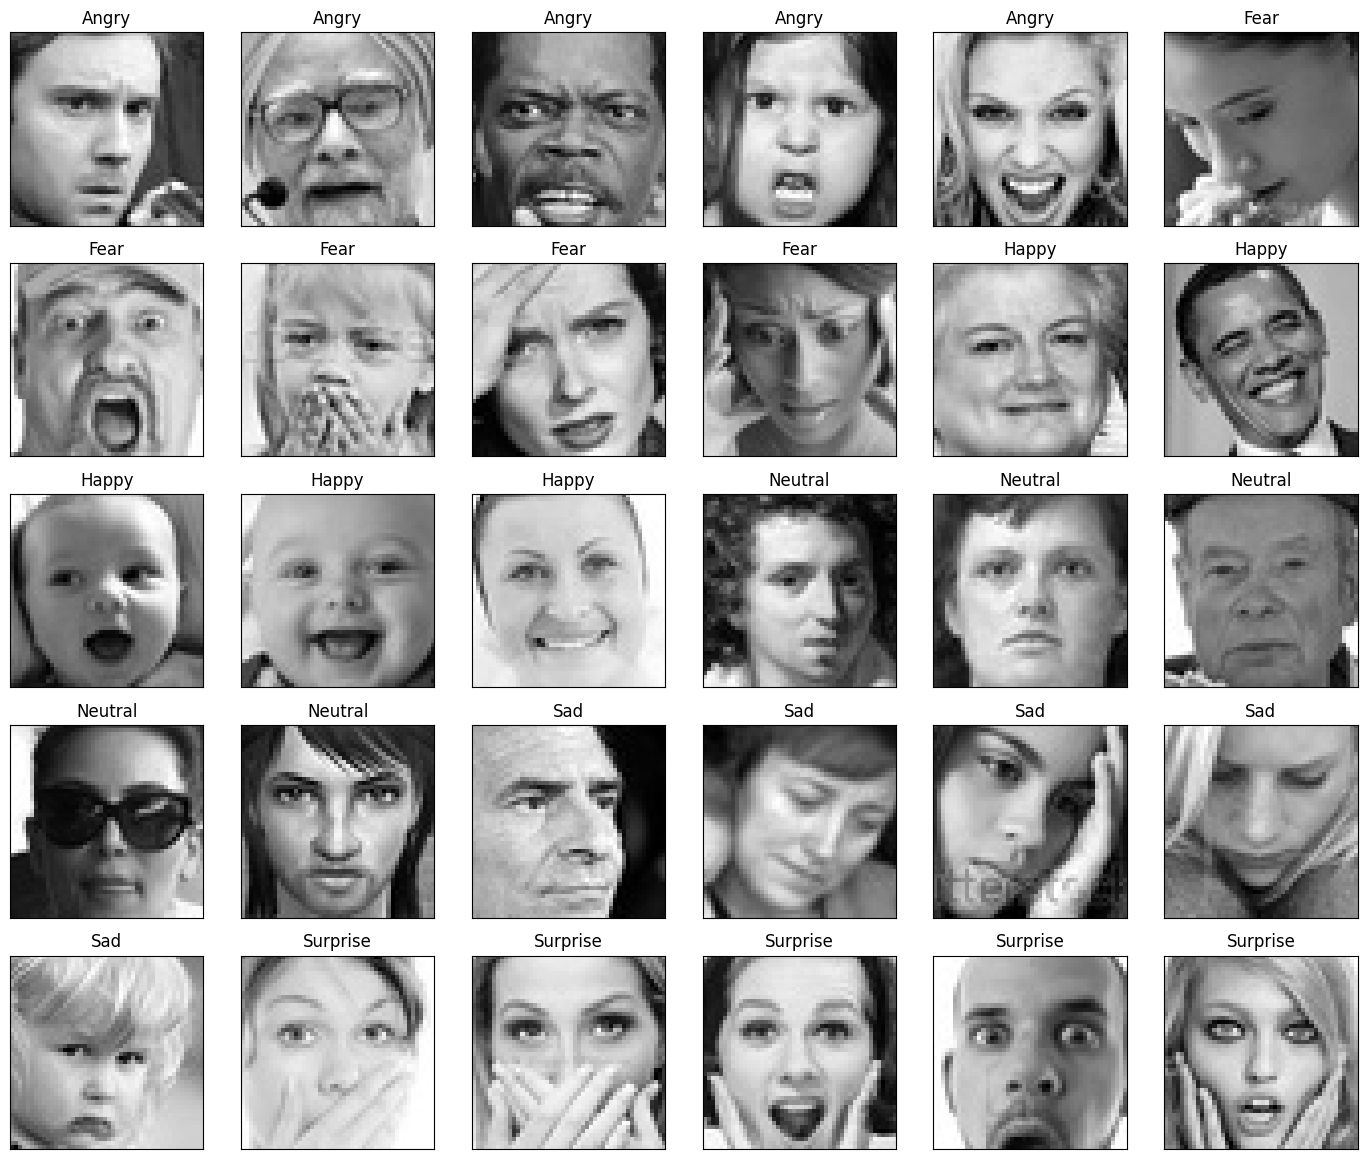

<Figure size 1400x800 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
label_to_text = {
    0: 'Angry',
    1: 'Fear',
    2: 'Happy',
    3: 'Neutral',
    4: 'Sad',
    5: 'Surprise'
}

fig = plt.figure(1, (14, 14))
k = 0

for label in sorted(data['emotion'].unique()):
    subset = data[data['emotion'] == label].head(5)  # Lấy 5 ảnh đầu của mỗi nhãn
    for i in range(len(subset)):
        pixel_string = subset.iloc[i]['pixels']
        px = np.array(pixel_string.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(6, 6, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        plt.tight_layout()

plt.figure(figsize=(14, 8))

In [25]:
# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
from sklearn.model_selection import train_test_split
x_data = data['pixels']
y_data = data['emotion']

In [26]:
# Thực hiện lấy mẫu ngẫu nhiên cho tập huấn luyện
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)


y_data.value_counts()

(42984, 1)   (42984,)


emotion
0    7164
1    7164
2    7164
3    7164
4    7164
5    7164
Name: count, dtype: int64

In [27]:
# Chuyển đổi dữ liệu thành 1 chiều
x_data = pd.Series(x_data.flatten())
x_data

# Chuyển đổi dữ liệu thành mảng numpy
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

# Chuyển đổi dữ liệu thành định dạng hình ảnh 48x48
x_data = x_data.reshape(-1, 48, 48, 1)
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)
     
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38685, 48, 48, 1), (4299, 48, 48, 1), (38685, 1), (4299, 1))

In [28]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, 6)
y_train.shape
y_test = to_categorical(y_test, 6)
y_test.shape
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((38685, 48, 48, 1), (4299, 48, 48, 1), (38685, 6), (4299, 6))

In [29]:
import numpy as np
print("Unique classes in y_data:", np.unique(y_data))
print("Sum of each column in one-hot y_train:", y_train.sum(axis=0))

Unique classes in y_data: [0 1 2 3 4 5]
Sum of each column in one-hot y_train: [6436. 6429. 6436. 6435. 6465. 6484.]


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
model = Sequential([
    # 1st Conv Layer
    Input((48, 48, 1)),
    Conv2D(64, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 2nd Conv Layer
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 3rd Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Dropout(0.25),

    # 4th Conv Layer
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # 5th Conv Layer
    Conv2D(256, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Flattening the Layer
    Flatten(),

    # Hidden Layer
    Dense(128, activation='relu'),
    Dropout(0.25),
    
     Dense(256, activation='relu'),
    Dropout(0.2),

    # Output Layer
    Dense(6, activation = 'softmax')
])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 46, 46, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 21, 21, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,115,718 (4.26 MB)

 Trainable params: 1,114,438 (4.25 MB)

 Non-trainable params: 1,280 (5.00 KB)

Epoch 1/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 302s 247ms/step - accuracy: 0.2616 - loss: 1.7313 - val_accuracy: 0.3736 - val_loss: 1.5214
Epoch 2/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 286s 236ms/step - accuracy: 0.3912 - loss: 1.4908 - val_accuracy: 0.4655 - val_loss: 1.3427
Epoch 3/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 282s 234ms/step - accuracy: 0.4592 - loss: 1.3522 - val_accuracy: 0.5117 - val_loss: 1.2345
Epoch 4/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 289s 239ms/step - accuracy: 0.5026 - loss: 1.2553 - val_accuracy: 0.5308 - val_loss: 1.1895
Epoch 5/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 289s 239ms/step - accuracy: 0.5297 - loss: 1.1946 - val_accuracy: 0.5473 - val_loss: 1.1328
Epoch 6/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 268s 222ms/step - accuracy: 0.5659 - loss: 1.1201 - val_accuracy: 0.5804 - val_loss: 1.0704
Epoch 7/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 267s 221ms/step - accuracy: 0.5918 - loss: 1.0625 - val_accuracy: 0.6080 - val_loss: 1.0208
Epoch 8/100
1209/1209 ━━━━━━━━━━━━━━━━━━━━ 266s 220ms/s

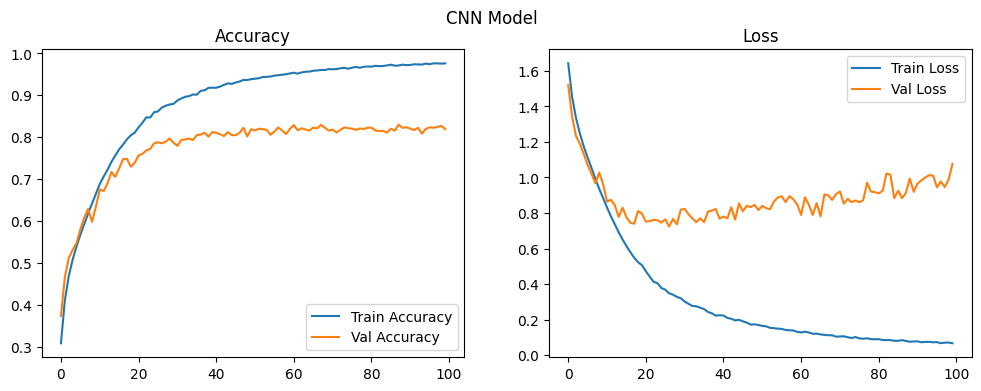

In [31]:
# Compile mô hình
from tensorflow import keras
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
x_train.shape, x_test.shape, y_train.shape, y_test.shape

adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
# Train mô hình
history = model.fit(x_train, y_train, epochs = 100, validation_data=(x_test, y_test))

print("Accuracy of our model on test data : " , model.evaluate(x_test, y_test)[1]*100 , "%")
print("Loss of our model on test data : " , model.evaluate(x_test, y_test)[0])

model.save('Model_CNN.keras')
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")

plt.suptitle("CNN Model")  # Tiêu đề cho toàn bộ figure
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step
📋 Classification Report:

              precision    recall  f1-score   support

       angry       0.86      0.83      0.85       728
        fear       0.74      0.86      0.79       735
       happy       0.86      0.77      0.82       728
     neutral       0.79      0.76      0.78       729
         sad       0.75      0.73      0.74       699
    surprise       0.92      0.97      0.94       680

    accuracy                           0.82      4299
   macro avg       0.82      0.82      0.82      4299
weighted avg       0.82      0.82      0.82      4299



C:\Users\DELL\AppData\Local\Temp\ipykernel_8712\1713944105.py:22: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

C:\Users\DELL\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


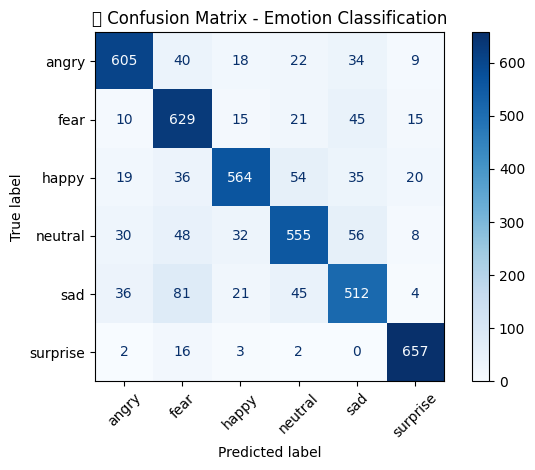

In [32]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Dự đoán xác suất
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

class_labels = ['angry', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 📋 In báo cáo phân loại với nhãn
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# 📊 Vẽ ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("📊 Confusion Matrix - Emotion Classification")
plt.tight_layout()
plt.show()